In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
# from scipy import optimize as op

In [48]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
#     'font.size' : 14.4,
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [3]:
# df_NP = pd.read_csv('data/Au_NP.txt',sep='\t',header=18)
# df_base = pd.read_csv('data/HAuCl4_solution.txt',sep='\t',header=18)
# df_epsilon = pd.read_csv('data/epsilon_bulk_Au.txt',sep='\t')

# df_NP.to_csv('data/Au_NP.csv',index=False)
# df_base.to_csv('data/HAuCl4_solution.csv', index=False)
# df_epsilon.to_csv('data/epsilon_bulk_Au.csv',index=False)


df_NP = pd.read_csv('data/Au_NP.csv')
df_base = pd.read_csv('data/HAuCl4_solution.csv')
df_epsilon = pd.read_csv('data/epsilon_bulk_Au.csv')

def access(df,lam,key):
    lam_0 = df['lambda'][0]
    i = int(lam - lam_0)
    return df[key][i]

<IPython.core.display.Javascript object>


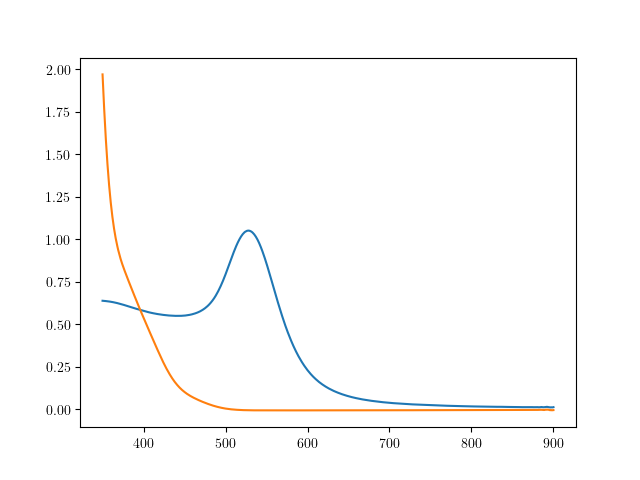

In [4]:
%matplotlib notebook
plt.figure()
plt.plot(df_NP['lambda'],df_NP['A'])
plt.plot(df_base['lambda'],df_base['A'])

<IPython.core.display.Javascript object>


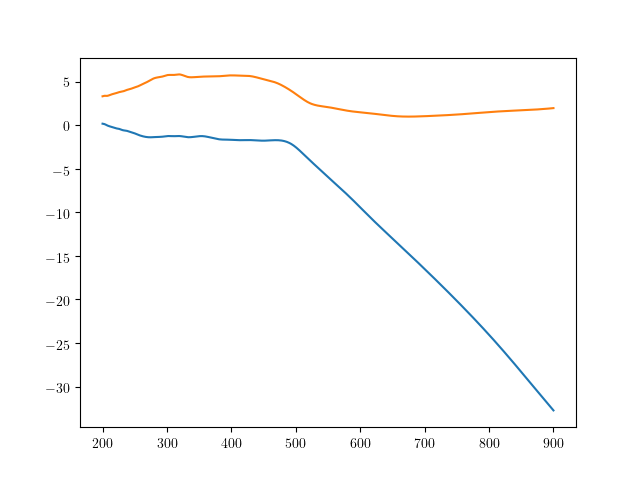

In [5]:
plt.figure()
plt.plot(df_epsilon['lambda'], df_epsilon['eps_1'])
plt.plot(df_epsilon['lambda'], df_epsilon['eps_2'])

In [6]:
z = 0.01*10**9 # thickness of the sample in nm


@np.vectorize
def absorbance(lam, eps_m, f):
    eps_1 = access(df_epsilon,lam,'eps_1')
    eps_2 = access(df_epsilon,lam,'eps_2')
    
    return 18*np.pi*z/(np.log(10)*lam)*eps_m**1.5*f*eps_2/((eps_1 + 2*eps_m)**2 + eps_2**2)
    


<IPython.core.display.Javascript object>


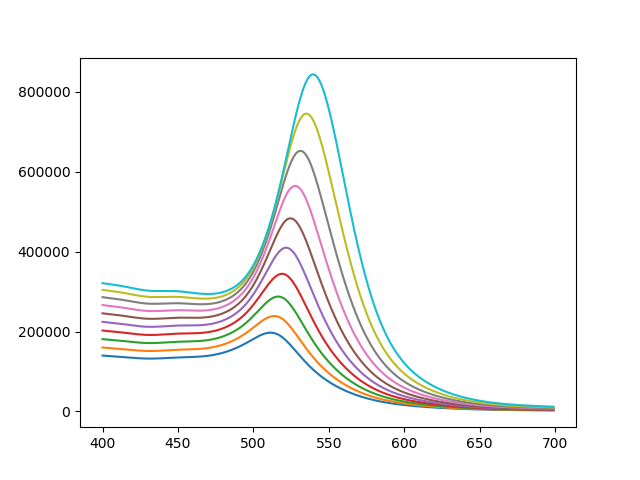

In [7]:
lams = np.arange(400,700)
eps_ms = np.linspace(1.1,1.6,10)**2

plt.figure()
for eps_m in eps_ms:
    As = absorbance(lams,eps_m,1)
    plt.plot(lams,As)

In [7]:
def r_chi2(func, xdata, ydata, args):
    '''
    func(x, *args)
    '''
    ddof = len(xdata) - len(args)
    return np.sum((ydata - func(xdata, *args))**2)/ddof

def make_args_list(args):
    '''
    args is a list of arrays: each of them contains the possible values for that parameter
    '''
    lens = [len(a) for a in args]
    return np.array(np.meshgrid(*args)).T.reshape(np.product(lens),len(lens))


def r_chi2_map(func, xdata, ydata, args_list, ofile='',columns=['eps_m','f','chi2']):
    df = pd.DataFrame(data=[],columns=columns)
    for args in tqdm(args_list):
        chi2 = r_chi2(func,xdata,ydata,args)
        df.loc[len(df)] = list(args) + [chi2]
    if ofile != '':
        df.to_csv(ofile,index=False)
    return df
    

## Without size correction

In [17]:
fs = np.linspace(1.4e-6,2.4e-6,100)
eps_ms = np.linspace(1.9,2.5,100)

lams = np.arange(500,600)
As = np.array([access(df_NP,lam,'A') for lam in lams])

r_chi2s = np.array(r_chi2_map(absorbance,lams,As,make_args_list([eps_ms,fs]))['chi2'])

100%|██████████| 10000/10000 [00:50<00:00, 198.27it/s]


In [18]:
print(np.min(r_chi2s))
make_args_list([eps_ms,fs])[np.argmin(r_chi2s)]

0.011306576162362976


array([2.22727273e+00, 1.81414141e-06])

<IPython.core.display.Javascript object>


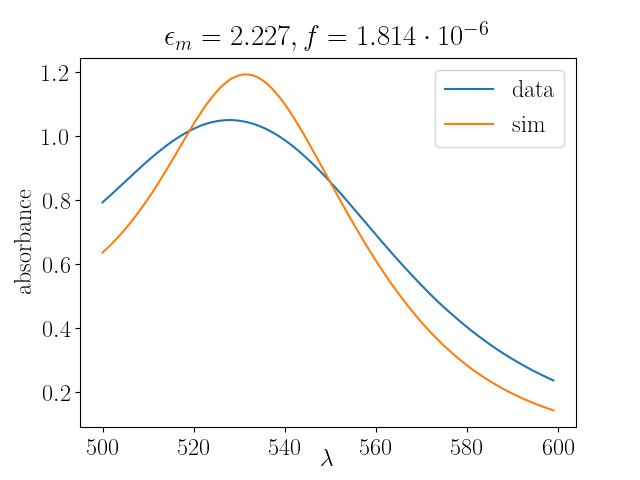

In [90]:
eps_m = 2.227
f = 1.814e-06

name = 'part1_fine_scan_500-600_best'

fig,ax = plt.subplots()
plt.plot(lams,As,label='data')
plt.plot(lams,absorbance(lams,eps_m,f),label='sim')
plt.legend()

plt.xlabel('$\lambda$')
plt.ylabel('absorbance')
plt.title('$\epsilon_m = %.3f, f = %.3f\cdot 10^{-6}$' %(eps_m,10**6*f))
ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

<IPython.core.display.Javascript object>


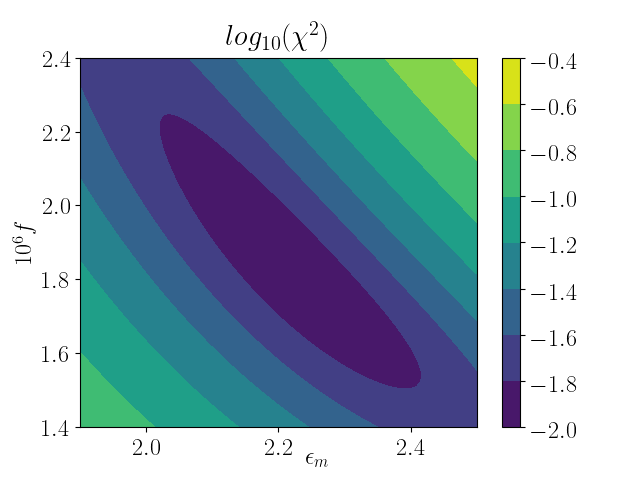

In [19]:
%matplotlib notebook
name = 'part1_fine_scan_500-600'

Eps_m, F = np.meshgrid(eps_ms,fs)


fig,ax = plt.subplots()
plt.contourf(Eps_m,1e6*F,np.log10(r_chi2s.reshape(len(eps_ms),len(fs)).T))
plt.colorbar()

plt.xlabel('$\epsilon_m$')
plt.ylabel('$10^6 f$')
plt.title('$log_{10}(\chi^2)$')

ax.xaxis.set_label_coords(0.6,-0.06)

# fig.savefig('../report/img/'+name+'.pgf')
# fig.savefig('../report/img/'+name+'.png')

## Size correction

In [8]:
import scipy.constants as cts

# m_Au = 196.967*cts.m_p # Au mass in Kg
omega_p = 13e15 # plasmon frequency in Hz
gamma_b = 1.1e14 # bulk damping frequency in Hz
E_F = 2.5 # Fermi energy in eV
v_F = np.sqrt(2*cts.e*E_F/cts.m_e)*10**9 # fermi velocity in nm/s

In [9]:
def eps_SC(lam,R):
    omega = 2*np.pi*cts.c*10**9/lam
    
    eps_1_b = access(df_epsilon,lam,'eps_1')
    eps_2_b = access(df_epsilon,lam,'eps_2')
    
    gamma = gamma_b + np.pi/4*v_F/R
    
    eps_1 = eps_1_b + 1/((omega/omega_p)**2 + (gamma_b/omega_p)**2) - 1/((omega/omega_p)**2 + (gamma/omega_p)**2)
    
    eps_2 = eps_2_b - gamma_b/omega/((omega/omega_p)**2 + (gamma_b/omega_p)**2) + gamma/omega/((omega/omega_p)**2 + (gamma/omega_p)**2)
    
    return eps_1, eps_2

@np.vectorize
def absorbance_SC(lam,eps_m,rho,R):
    eps_1, eps_2 = eps_SC(lam,R)
    return 18*np.pi*z/(np.log(10)*lam)*eps_m**1.5*rho*(4*np.pi*R**3/3)*eps_2/((eps_1 + 2*eps_m)**2 + eps_2**2)


@np.vectorize
def absorbance_SCf(lam,eps_m,f,R):
    eps_1, eps_2 = eps_SC(lam,R)
    return 18*np.pi*z/(np.log(10)*lam)*eps_m**1.5*f*eps_2/((eps_1 + 2*eps_m)**2 + eps_2**2)

<IPython.core.display.Javascript object>


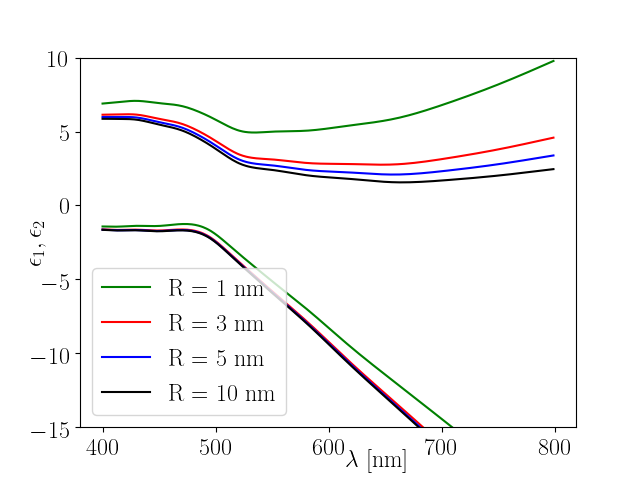

In [156]:
%matplotlib notebook
Rs = [1,3,5,10]
colors = ['green','red','blue','black']
lams = np.arange(400,800)

fig,ax = plt.subplots()

for i,R in enumerate(Rs):
    eps_1s = []
    eps_2s = []
    for lam in lams:
        eps_1, eps_2 = eps_SC(lam,R)
        eps_1s.append(eps_1)
        eps_2s.append(eps_2)

    plt.plot(lams,eps_1s,label='R = %d nm' %R,color=colors[i])
    plt.plot(lams,eps_2s,label='',color=colors[i])
plt.legend()

plt.ylim(-15,10)

plt.xlabel('$\lambda$ [nm]')
plt.ylabel(r'$\epsilon_1,\epsilon_2$')

ax.xaxis.set_label_coords(0.6,-0.06)
ax.yaxis.set_label_coords(-0.06,0.5)
plt.savefig('../report/img/eps_SC.png')

In [37]:
#SC with rho

rhos = np.linspace(4e-11,4e-7,100)
eps_ms = np.linspace(1.7,2.6,50)
Rs = np.arange(1,21)

lams = np.arange(400,700)
As = np.array([access(df_NP,lam,'A') for lam in lams])

df_chi2 = r_chi2_map(absorbance_SC,lams,As,make_args_list([eps_ms,rhos,Rs]),columns=['eps_m','rho','R','chi2'],
                     ofile='SC_chi2_map_scan_400-700_coarse.csv')

In [143]:
#SCf with f

fs = np.linspace(2.2e-6,3e-6,100)
eps_ms = np.linspace(1.9,2.14,50)
Rs = np.arange(2,6,0.2)

lams = np.arange(450,600)
As = np.array([access(df_NP,lam,'A') for lam in lams])

df_chi2 = r_chi2_map(absorbance_SCf,lams,As,make_args_list([eps_ms,fs,Rs]),columns=['eps_m','f','R','chi2'],
                     ofile='SCf_chi2_map_scan_450-600_fine.csv')

100%|██████████| 100000/100000 [18:06<00:00, 92.07it/s]


In [12]:
df_chi2 = pd.read_csv('SC_chi2_map_scan_400-700_coarse.csv')

In [34]:
def integrate(df,free_axes,int_axis,v_min,v_max):  ## this way it does not work
    keys = df.keys()
    new_df = pd.DataFrame(data=[],columns=[keys[j] for j in free_axes] + ['chi2'])
    old_pars = []
    pars = []
    for i in tqdm(range(len(df))):
        v = df[keys[int_axis]][i]
        if v >= v_min and v <= v_max:
            pars = [df[keys[j]][i] for j in free_axes]
            found = False
            for h in range(1,len(old_pars)+1):
                p = old_pars[len(old_pars) - h]
                if p == pars:
                    new_df['chi2'][len(old_pars) - h] += df['chi2'][i]
                    found = True
                    break
            if not found:
                old_pars.append(pars)
                new_df.loc[len(new_df)] = pars + [df['chi2'][i]]
    
    return new_df

In [144]:
i_min = np.argmin(np.array(df_chi2['chi2']))

print(df_chi2.keys(),i_min)
df_chi2.loc[i_min]

Index(['eps_m', 'f', 'R', 'chi2'], dtype='object') 32849


eps_m    2.037143
f        0.000003
R        3.200000
chi2     0.000680
Name: 32849, dtype: float64

In [145]:
df_chi2['f'][i_min]

2.5959595959595963e-06

100%|██████████| 100000/100000 [00:03<00:00, 33002.32it/s]


<IPython.core.display.Javascript object>


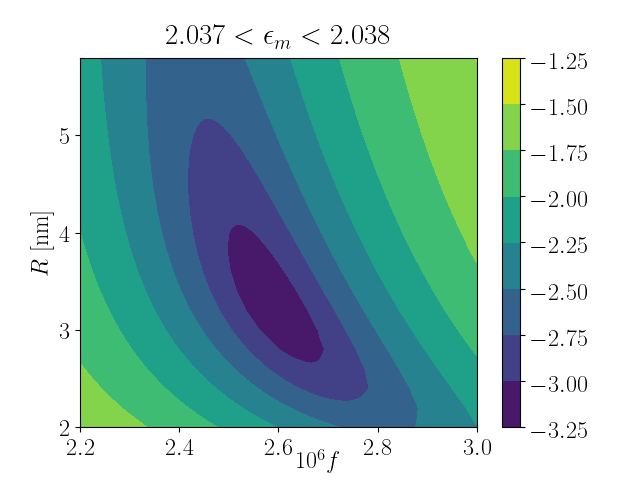

In [146]:
v_min = 2.037
v_max = 2.038

name = 'part1_fine_scan_450-600_Rf_SCf'

df = integrate(df_chi2,[1,2],0,v_min,v_max)
chi2s = np.array(df['chi2'])

fig,ax = plt.subplots()
rrhos, RRs = np.meshgrid(rhos,Rs)
plt.contourf(10**6*fs,Rs,np.log10(chi2s.reshape(len(Rs),len(fs))))
plt.xlabel('$10^6f$')
plt.ylabel('$R$ [nm]')
plt.title('$%.3f < \epsilon_m < %.3f$' %(v_min,v_max))
plt.colorbar()

ax.xaxis.set_label_coords(0.6,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

100%|██████████| 100000/100000 [00:01<00:00, 50950.03it/s]


<IPython.core.display.Javascript object>


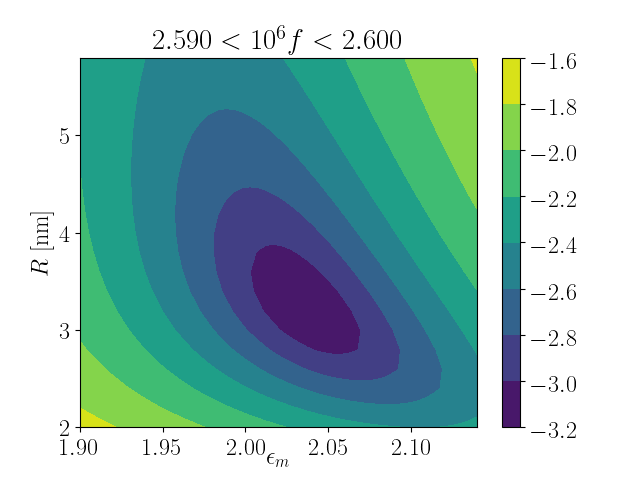

In [147]:
v_min = 2.59e-6
v_max = 2.60e-6

name = 'part1_fine_scan_450-600_Re_SCf'

df = integrate(df_chi2,[0,2],1,v_min,v_max)
chi2s = np.array(df['chi2'])

fig,ax = plt.subplots()
plt.contourf(eps_ms,Rs,np.log10(chi2s.reshape(len(Rs),len(eps_ms))))
plt.xlabel('$\epsilon_m$')
plt.ylabel('$R$ [nm]')
plt.title('$%.3f < 10^6 f < %.3f$' %(10**6*v_min,10**6*v_max))
plt.colorbar()

ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

100%|██████████| 100000/100000 [00:07<00:00, 14276.42it/s]


<IPython.core.display.Javascript object>


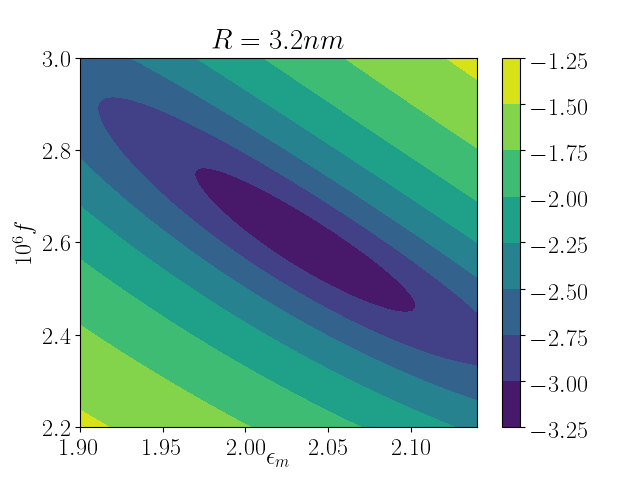

In [148]:
v_min = 3.2
v_max = 3.22

name = 'part1_fine_scan_450-600_fe_SCf'

df = integrate(df_chi2,[0,1],2,v_min,v_max)
chi2s = np.array(df['chi2'])

fig,ax = plt.subplots()
plt.contourf(eps_ms,10**6*fs,np.log10(chi2s.reshape(len(eps_ms),len(fs)).T))
plt.xlabel('$\epsilon_m$')
plt.ylabel('$10^6 f$')
plt.title('$R = %.1f nm$' %(v_min))
plt.colorbar()

ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

In [62]:
df_chi2.loc[17146]

2.085714285714286

<IPython.core.display.Javascript object>


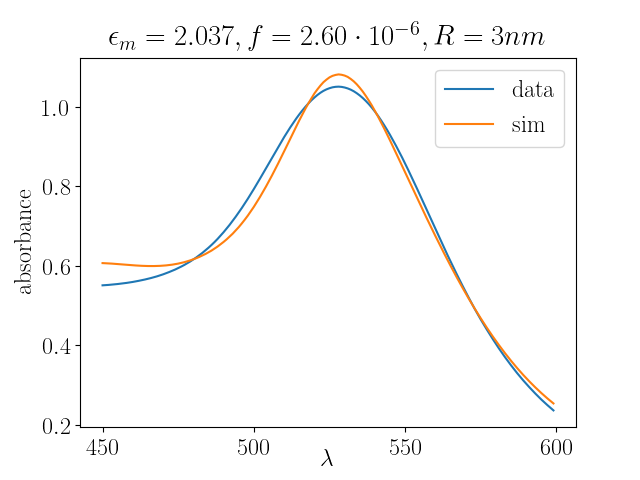

In [150]:
eps_m = 2.0373
f = 2.5959e-6
R = 3.2

name = 'part1_fine_scan_450-600_best_SCf'

fig,ax = plt.subplots()
plt.plot(lams,As,label='data')
plt.plot(lams,absorbance_SCf(lams,eps_m,f,R),label='sim')
plt.legend()

plt.xlabel('$\lambda$')
plt.ylabel('absorbance')
plt.title(r'$\epsilon_m = %.3f, f = %.2f\cdot 10^{-6}, R = %d nm$' %(eps_m,10**6*f,R))
ax.xaxis.set_label_coords(0.5,-0.06)

fig.savefig('../report/img/'+name+'.pgf')
fig.savefig('../report/img/'+name+'.png')

# 3D plot: stability basin

In [17]:
from mpl_toolkits.mplot3d import Axes3D

In [18]:
df = pd.read_csv('./SCf_chi2_map_scan_450-600_fine.csv')
min_chi2 = np.min(df['chi2'])
print(min_chi2)
df.keys()

0.0006799053189972343


Index(['eps_m', 'f', 'R', 'chi2'], dtype='object')

<IPython.core.display.Javascript object>


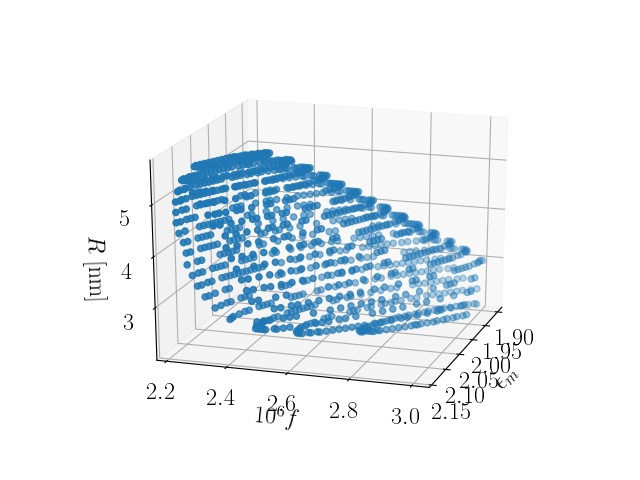

100%|██████████| 100000/100000 [00:01<00:00, 91249.26it/s]


In [55]:
u = 3
l = 2.9

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('$\epsilon_m$')
ax.set_ylabel('$10^6 f$')
ax.set_zlabel('$R$ [nm]')

xs = []
ys = []
zs = []
for i in tqdm(range(len(df))):
    if df['chi2'][i] < u*min_chi2 and df['chi2'][i] > l*min_chi2:
        xs.append(df['eps_m'][i])
        ys.append(df['f'][i]*10**6)
        zs.append(df['R'][i])

# ax.plot_trisurf(xs,ys,zs)
ax.scatter(xs,ys,zs)

<IPython.core.display.Javascript object>


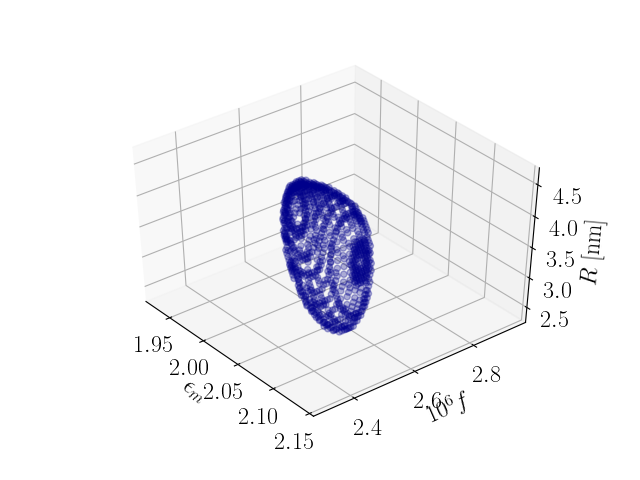

100%|██████████| 100000/100000 [00:01<00:00, 93980.82it/s]


In [54]:
%matplotlib notebook
lus = [[1,1.1],[1.9,2]][1:]
colors = ['darkblue', 'lightblue']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('$\epsilon_m$')
ax.set_ylabel('$10^6 f$')
ax.set_zlabel('$R$ [nm]')
# ax.xaxis.set_label_coords(0.5,-0.06,0)
ax.yaxis.set_label_coords(-0.1,0.5,0)

for j,(l,u) in enumerate(lus):
    xs = []
    ys = []
    zs = []
    for i in tqdm(range(len(df))):
        if df['chi2'][i] < u*min_chi2 and df['chi2'][i] > l*min_chi2:
            xs.append(df['eps_m'][i])
            ys.append(df['f'][i]*10**6)
            zs.append(df['R'][i])

    # ax.plot_trisurf(xs,ys,zs)
    ax.scatter(xs,ys,zs, color=colors[j],alpha=0.3)